In [1]:
import os
import textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pprint import pprint
from itertools import combinations, cycle, islice
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction import DictVectorizer
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association

In [2]:
from metagov import cryptopolitics
from metagov.cryptopolitics import SAVEDIR, QUESTIONS, CHOICES, COLS_QUESTIONS, COLS_RESULTS, q2n, n2q, FACTION_ORDERS
from metagov.utils import print_groupby

In [3]:
# Figure export settings
SAVEFIG = True
fig_ext = '.png'
fig_kwargs = cryptopolitics.KWARGS_PNG

# Cryptopolitical Typology Quiz analysis: distribution of responses

The [Cryptopolitical Typology Quiz](https://metagov.typeform.com/cryptopolitics) was developed by the [Metagovernance Project](https://metagov.org/) to help the crypto community understand its political, economic, and governance beliefs. Survey results were collected from September 27, 2021 through March 4, 2022 and have been published on the [Govbase Airtable database](https://airtable.com/shr9LYMni8pBUVD6q/tblvwbt4KFm8MOSUQ). 

This notebook includes:
- Importing the data
- Response rates
- Distribution of (and correlation between) faction assignments
- Distribution of (and correlation between) responses to individual questions
- Bitcoin versus Ethereum

To run this analysis notebook yourself, you will need an Airtable API key. If you are interested in supporting the Cryptopolitics project, please get in touch with [josh@metagov.org](josh@metagov.org), drop a coin in our [Gitcoin grant](https://gitcoin.co/grants/1573/govbase-a-database-for-daos-and-other-online-comm), or join us in the [Metagov Discord](https://discord.gg/7k26vVvY9e).

In [4]:
# Load data
data = cryptopolitics.load_data()
df_questions, df_results = data.values()

df_questions.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19
id,,,,,,,,,,,,,,,,,,,
3462,There is one (layer 1) blockchain that is the ...,NaN,Crypto is mainly a political philosophy and/or...,My goal in crypto is to earn a living and/or b...,Most or all cryptogovernance should be on-chain.,Privacy is the most important feature of block...,Government regulation of crypto can do some go...,Having a central bank run a cryptocurrency is ...,Provide financial instruments for maximum weal...,Blockchain and DeFi are beneficial technologie...,Crypto teams make too much profit.,The economic system in crypto is generally fai...,Most people who want to get ahead in crypto ca...,Hire lawyers and lobbyists; organize the commu...,Crypto does not have a gender problem.,"The token holders and/or node operators, i.e. ...",the tech,Liberal or left-wing,[AVAX]
2024,There is no one best blockchain.,NaN,Crypto is mainly a political philosophy and/or...,My goal in crypto is to create social change a...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto will almost al...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Most crypto teams make a fair and reasonable a...,The economic system in crypto is generally fai...,Most people who want to get ahead in crypto ca...,Adapt our technology and practices in order to...,Crypto does not have a gender problem.,A wide variety of on- and off-chain stakeholde...,the tech,Neither,[Ethereum]
2135,There is no one best blockchain.,NaN,Crypto is mainly an economic technology.,My goal in crypto is to make as much money as ...,Crypto does not need (human) governance; let t...,Privacy is the most important feature of block...,Government regulation of crypto will almost al...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Most crypto teams make a fair and reasonable a...,The economic system in crypto unfairly favors ...,"In crypto, hard work and determination are no ...","Keep on doing what we’re doing, legal or not.",Crypto does not have a gender problem.,The core developers and technical staff of a b...,the airdrops,Conservative or right-wing,[Ethereum]
3389,There is no one best blockchain.,NaN,Crypto is mainly an economic technology.,My goal in crypto is to make as much money as ...,Crypto does not need (human) governance; let t...,Privacy is the most important feature of block...,Government regulation of crypto will almost al...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Crypto teams make too much profit.,The economic system in crypto unfairly favors ...,Most people who want to get ahead in crypto ca...,NaN,Crypto does not have a gender problem.,A wide variety of on- and off-chain stakeholde...,NaN,Neither,"[Bitcoin, Ethereum]"
449,There is one (layer 1) blockchain that is the ...,Ethereum,Crypto is mainly a political philosophy and/or...,My goal in crypto is to make as much money as ...,Most or all cryptogovernance should be on-chain.,Privacy is the most important feature of block...,Government regulation of crypto will almost al...,Having a central bank run a cryptocurrency is ...,Build art and community.,Blockchain and DeFi are beneficial technologie...,Crypto teams make too much profit.,The economic system in crypto unfairly favors ...,"In crypto, hard work and determination are no ...","Keep on doing what we’re doing, legal or not.",Crypto has a gender problem.,A wide variety of on- and off-chain stakeholde...,the memes,Neither,[Ethereum]


In [5]:
# Typical number of affiliations recorded
def get_affiliations(values):
    if isinstance(values, list):
        v = [x for x in values if x != 'None']
        v = [(x if x in ['Ethereum', 'Bitcoin', 'Solana', 'Polkadot', 'Cardano'] else 'Other') for x in v]
    else:
        v = values
    return v            

df_questions['Q19_all'] = df_questions['Q19']
df_questions['Q19'] = df_questions['Q19_all'].apply(get_affiliations)

In [6]:
# Typical number of affiliations recorded
def get_affiliation_count(values):
    if values is np.nan:
        count = np.nan
    elif len(values) >= 2:
        count = 'Two or more'
    else:
        v = [x for x in values if x != 'None']
        if len(v) == 0:
            count = 'None'
        else:
            count = 'One'
    return count

col = 'Q19_count'
df_questions[col] = df_questions['Q19'].apply(get_affiliation_count)

In [7]:
NO_ANSWER = '(No answer)'
df_questions_nonan = df_questions.copy(deep=True).fillna(NO_ANSWER)

## Response rates
How many respondents were there, and how thoroughly did they fill out the survey?

In [8]:
# Q2 and Q19 ask about affiliations with specific blockchains, ecosystems, or
# other crypto communities.

df_tmp = df_questions.copy().drop(columns=['Q2', 'Q19', 'Q19_all', 'Q19_count'])
gb_tmp = df_tmp.groupby(list(df_tmp.columns), dropna=False)
nResponses = len(df_tmp.index)
print(f"Number of responses: {nResponses}")
print(f"Number of unique responses (ignoring Q2 and Q19): {gb_tmp.ngroups} ({100*gb_tmp.ngroups/nResponses:.1f}%)")
df_tmp = df_tmp.dropna()
print(f"Number of responses with no unanswered questions: {len(df_tmp.index)} ({100*len(df_tmp.index)/nResponses:.1f}%)")

Number of responses: 3710
Number of unique responses (ignoring Q2 and Q19): 3608 (97.3%)
Number of responses with no unanswered questions: 3418 (92.1%)


In [9]:
# This could help us know which questions or set of possible choices were
# insufficient to capture the range of beliefs held.
# Note that Q2 could only be answered if a particular response was given for Q1.

print("Percentage of respondents who chose not to answer each question:")
for col in COLS_QUESTIONS[:-1]:
    print(f"{col}:\t{100*df_questions[col].isnull().sum()/nResponses:.1f}%")

df_q2 = df_questions[df_questions['Q1'] == "There is one (layer 1) blockchain that is the best."]
nMaxis = len(df_q2.index)
print(f"Actual percentage for Q2: {100*df_q2['Q2'].isnull().sum()/nMaxis:.1f}%")

Percentage of respondents who chose not to answer each question:
Q1:	0.5%
Q2:	76.7%
Q3:	0.6%
Q4:	0.4%
Q5:	0.6%
Q6:	0.6%
Q7:	0.5%
Q8:	0.8%
Q9:	0.7%
Q10:	0.9%
Q11:	1.5%
Q12:	0.9%
Q13:	1.0%
Q14:	0.9%
Q15:	1.0%
Q16:	0.8%
Q17:	1.2%
Q18:	0.8%
Actual percentage for Q2: 6.3%


## Distribution of faction assignments
- What percentage of respondents were assigned each faction/class?
- Are faction/class assignments correlated? This is an indication of how independent our defined "axes" of politics, economics, and governance are.

In [10]:
def plot_pie_faction(col, df, colors=sns.color_palette("Set2")):
    """Plot pie chart for overall faction"""
    
    vals = df_results[col].value_counts()
    n = vals.sum()
    labels = [f"{k} ({100*v/n:.0f}%)" for k, v in vals.items()]
    
    plt.figure()
    fig = plt.pie(vals, labels=labels, colors=colors, wedgeprops=dict(width=0.5))
    
    if SAVEFIG:
        fname = f'{SAVEDIR}/cryptopolitics_faction_{col}'
        plt.savefig(f'{fname}.{fig_ext}', **fig_kwargs)

In [11]:
def cramers_v(q1, q2, verbose=False):
    """Calculate Cramer's V for two categorical questions by cross-tabulating"""
    
    assert len(q1.index) == len(q2.index), "Make sure the datasets are of equal length"
    
    # Skip questions with list as response
    try:
        ct = pd.crosstab(q1, q2)
    except TypeError:
        return np.nan
    
    chi2 = stats.chi2_contingency(ct)[0]
    n = len(q1.index)
    nRows, nCols = ct.shape
    minDim = min(nRows-1, nCols-1)
    
    # Only compute if both questions have at least two observed responses
    # E.g., Q2 is only answered if a particular answer is given to Q1
    if minDim == 0:
        return np.nan
    
    V = np.sqrt((chi2/n)/minDim)

    if verbose:   
        ct_norm = pd.crosstab(q1, q2, normalize=True)*100
        rowName = q1.name
        colName = q2.name
        rowList = cryptopolitics.FACTION_ORDERS[rowName]
        colList = cryptopolitics.FACTION_ORDERS[colName]
        ct_norm = ct_norm.reindex(rowList)[colList]
     
        sns.heatmap(ct_norm, annot=True, fmt="0.1f", cmap="YlGnBu", cbar_kws={'label': "Percentage of respondents"})
        
        if SAVEFIG:
            fname = f"{SAVEDIR}/cryptopolitics_{rowName}-{colName}_heatmap"
            plt.savefig(f'{fname}.{fig_ext}', **fig_kwargs)
    
    return V

In [12]:
def compute_cramers_v_matrix(df, method='cramer', verbose=False):
    """Compute Cramer's V for each pair of questions"""
    
    cols = list(df.columns)
    nCols = len(cols)
    cramersMatrix = np.zeros((nCols, nCols))
    for i, c1 in enumerate(cols):
        for j, c2 in enumerate(cols):
            # Select only rows for which both questions were answered
            df_tmp = df[pd.notnull(df[c1]) & pd.notnull(df[c2])]
            #value = cramers_v(df_tmp[c1], df_tmp[c2])
            ct = pd.crosstab(df_tmp[c1], df_tmp[c2]).to_numpy(dtype=int)
            value = association(ct, method=method)
            cramersMatrix[i, j] = value
            if verbose:
                print(f"{value:.2f} for {c1[:min(len(c1), 10)]} and {c2[:min(len(c1), 10)]}")
    return cramersMatrix

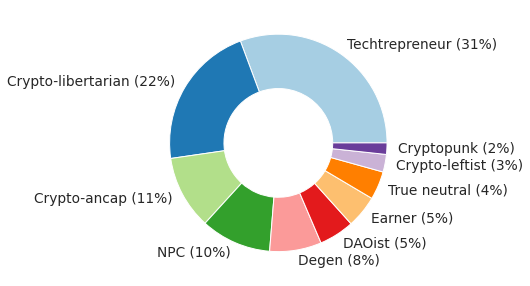

In [13]:
# Pie chart for overall faction assignments
plot_pie_faction('classification', df_results, colors=sns.color_palette("Paired"))

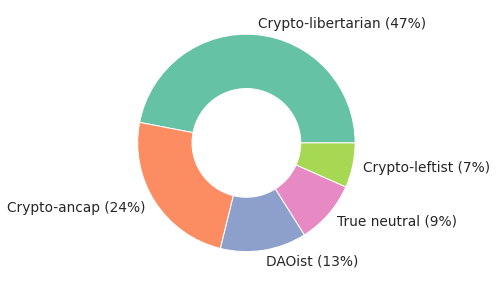

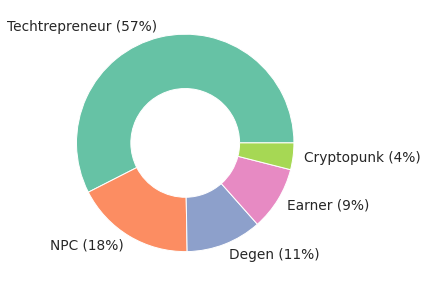

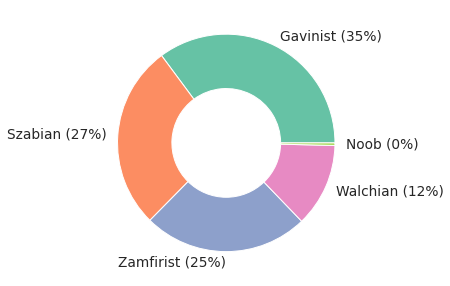

In [14]:
# Pie charts for specific dimensions of belief
for col in COLS_RESULTS[1:]:
    plot_pie_faction(col, df_results)

### Correlation between faction/class assignments
Plot cross-tabulation and calculate corresponding [Cramer's V](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V), a measure of correlation between categorical variables.


Correlation: 0.061


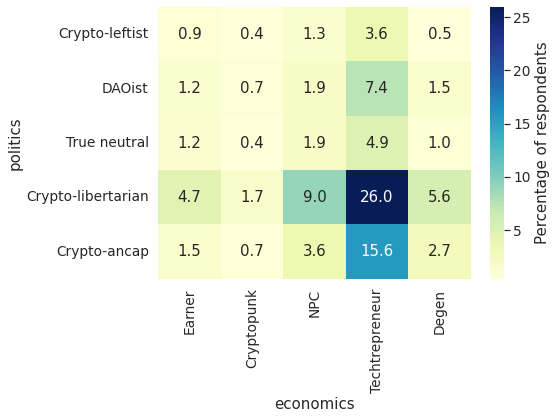

In [15]:
v = cramers_v(df_results['politics'], df_results['economics'], verbose=True)
print(f"\nCorrelation: {v:.3f}")


Correlation: 0.190


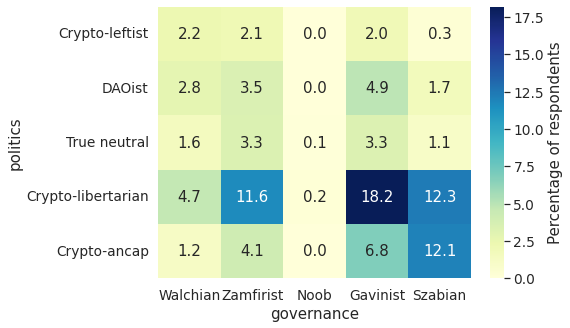

In [16]:
v = cramers_v(df_results['politics'], df_results['governance'], verbose=True)
print(f"\nCorrelation: {v:.3f}")


Correlation: 0.057


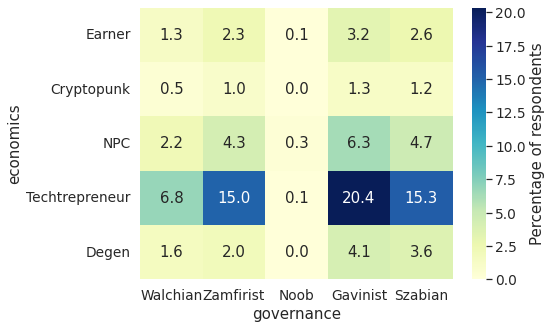

In [17]:
v = cramers_v(df_results['economics'], df_results['governance'], verbose=True)
print(f"\nCorrelation: {v:.3f}")

For politics-economics and economics-governance, the Cramer's V correlation values values are quite small (close to 0 on a 0 to 1 scale). **This indicates that these pairs of labels may suitably characterize two independent "axes" of belief.**

On inspection of the politics-governance cross-tabulation, **the proportion of crypto-ancaps who were Szabians (and vice versa) was higher than for the other faction combinations**. This makes sense given the aversion to centralized governance inherent in both of these labels.

## Distribution of responses to individual questions
-  What percentage of respondents chose each answer for each question? Reproduction of the plots from the live [Typeform response page](https://metagov.typeform.com/report/bz9SbjUU/ZY07qRfTs68oypzt) (as of 01/09/2022). Note that this excludes respondents who did not respond to the question.
- Are responses to individual questions correlated? This is an indication of whether the questions ask about distinct aspects of crypto beliefs.

In [18]:
def plot_cramers_v_matrix(df):
    """Plot heatmap of Cramer's V"""
    
    plt.figure(figsize=(8,8))
    fig = sns.heatmap(df, cmap=sns.color_palette("Blues", as_cmap=True), vmin=0, vmax=1, cbar_kws={'label': "Cramer's V"})
    fig.xaxis.set_ticks_position("top")
    fig.set_xticklabels(labels=df.columns, rotation=60)
    fig.set_aspect('equal')
    
    if SAVEFIG:
        fname = f'{SAVEDIR}/cryptopolitics_question_correlation_matrix'
        plt.savefig(f'{fname}.{fig_ext}', **fig_kwargs)

### What percentage of respondents chose each answer for each question? 

In [19]:
def bar_plot_coded_column(df, col, threshold=0, label=''):
    """Plot frequency of unique list items for coded columns"""
    
    # Make sure all values in column are lists
    df[col] = df[col].apply(lambda d: d if isinstance(d, list) else [])
    
    # One-hot encode column of lists
    mlb = MultiLabelBinarizer(sparse_output=True)
    df_onehot = pd.DataFrame.sparse.from_spmatrix(
        mlb.fit_transform(df[col]),
        index=df.index,
        columns=mlb.classes_)
    
    # Get count for each unique item
    df_sum = pd.DataFrame(df_onehot.sum()).sort_values(0, axis=0, ascending=False)
    df_sum = df_sum[df_sum[0] >= threshold]
    print(df_sum)
    
    # Plot bar chart of unique list items
    plt.plot()
    sns.barplot(data=df_sum.transpose(), orient='h')
    plt.ylabel(label)
    plt.xlabel('Frequency')
    
    if SAVEFIG:
        fname = f"{SAVEDIR}/cryptopolitics_{label}"
        plt.savefig(f'{fname}.{fig_ext}', **fig_kwargs)

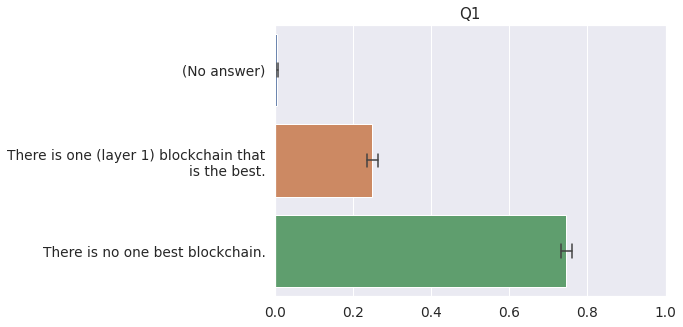

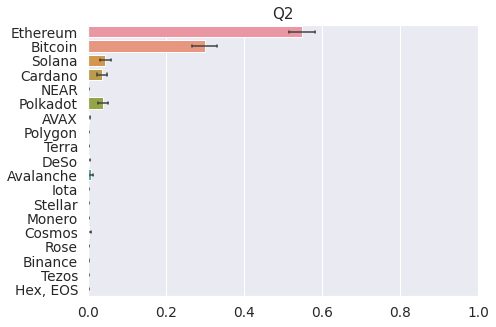

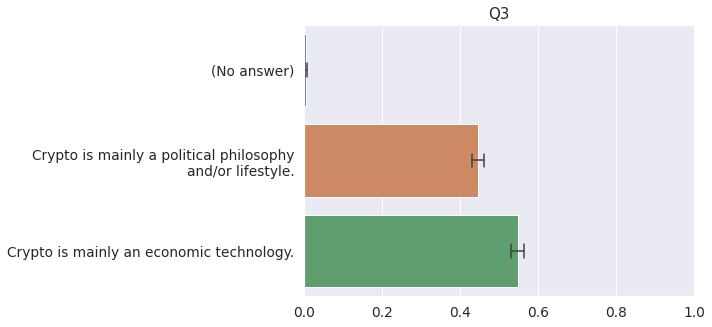

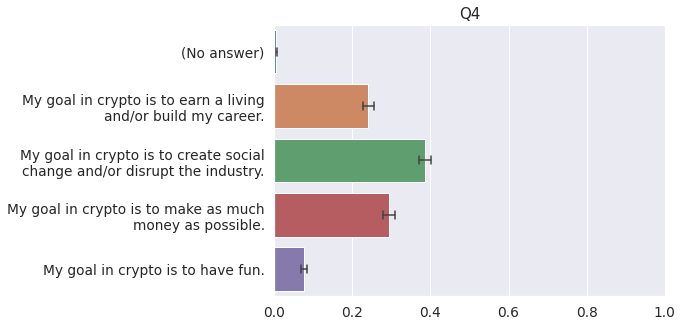

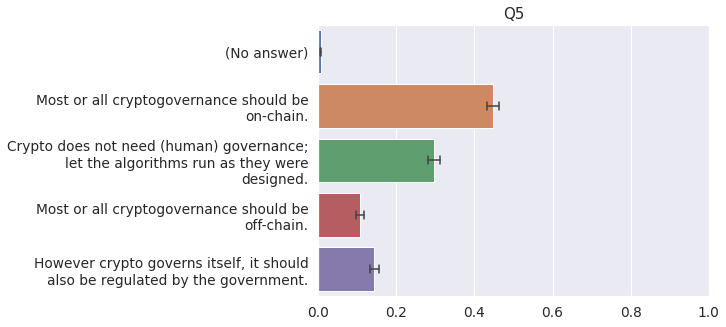

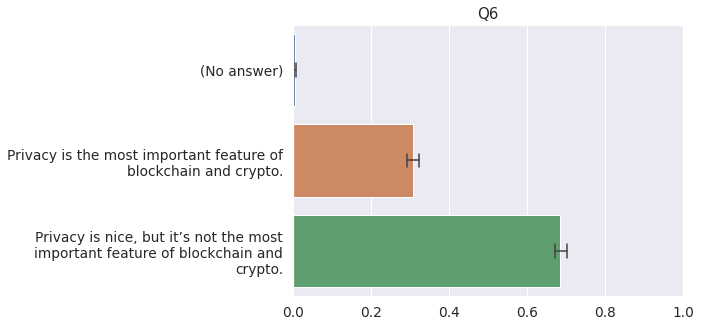

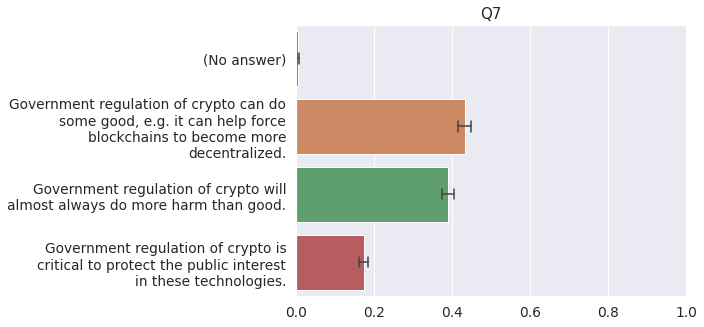

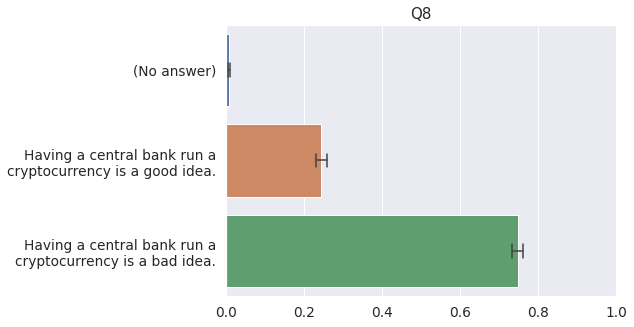

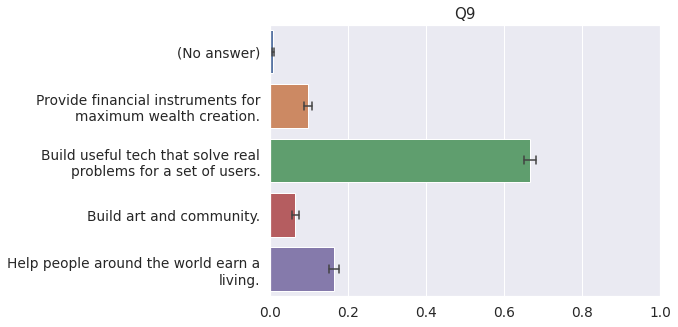

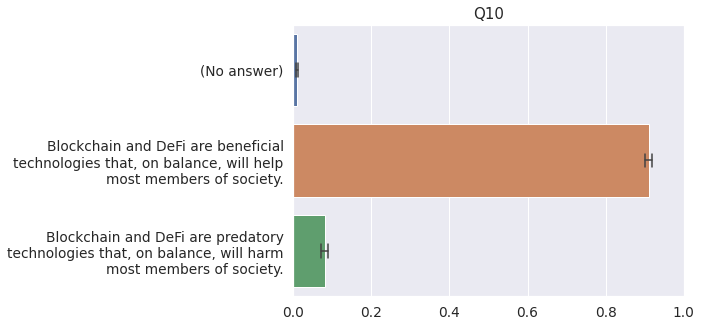

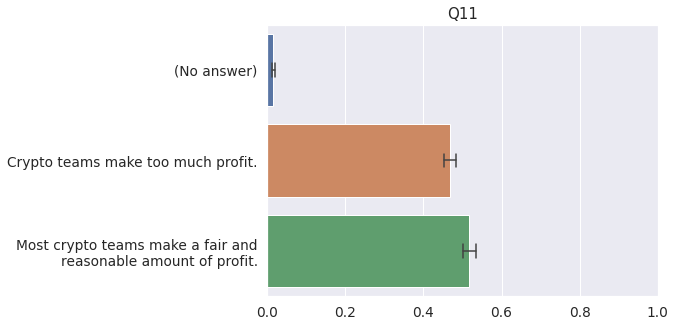

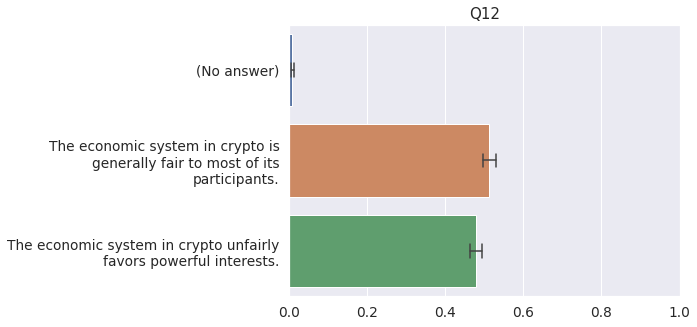

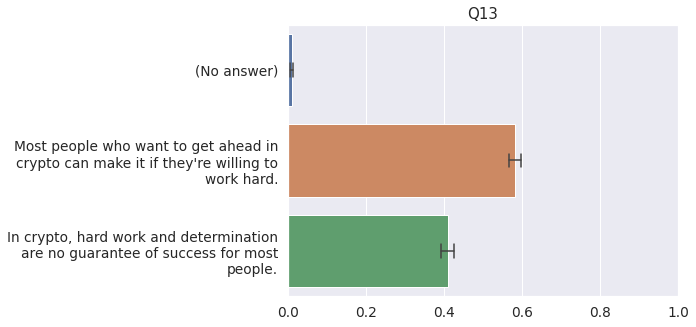

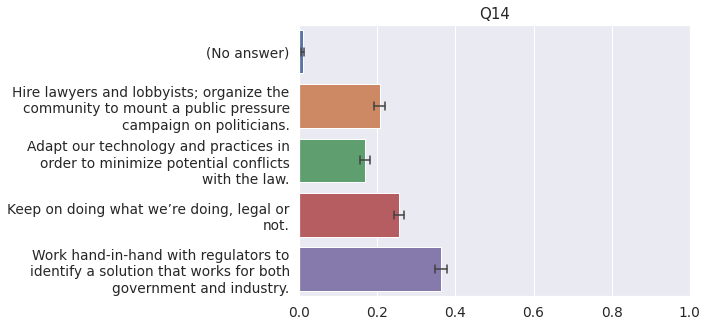

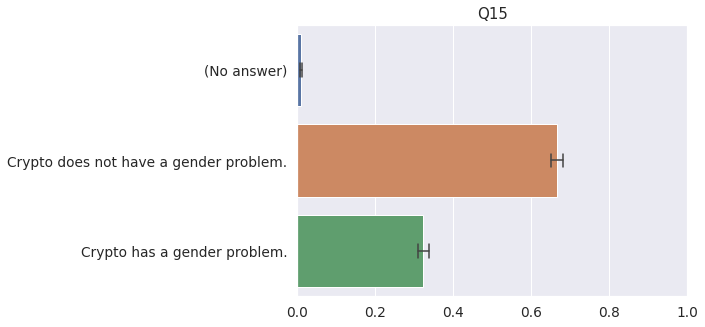

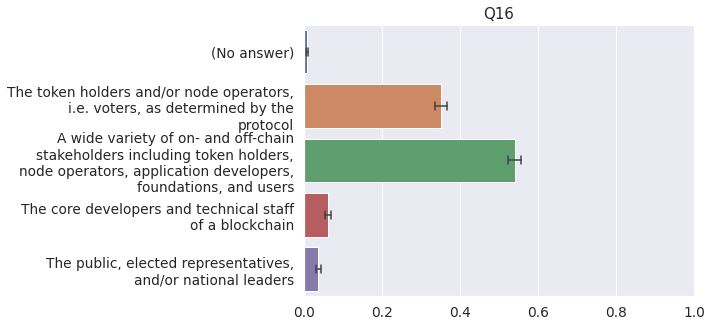

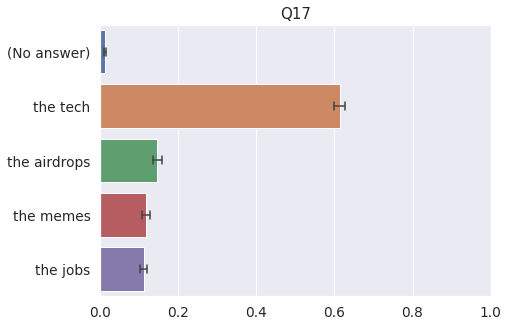

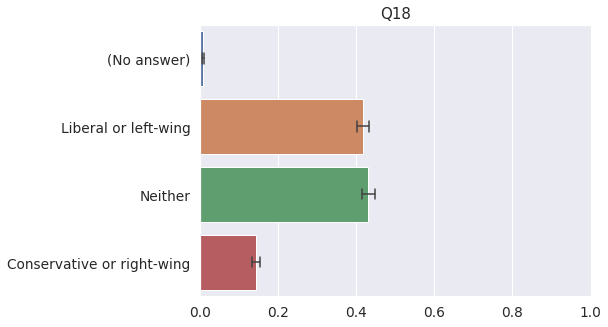

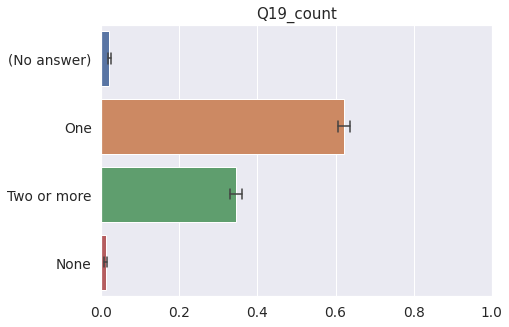

In [20]:
for col in [*COLS_QUESTIONS[:-1], 'Q19_count']:
    # Plot bar chart with margin of error for 95% confidence for each question
    
    if col == 'Q2':
        df_tmp = df_questions.dropna()
    else:
        df_tmp = df_questions_nonan
    
    # Get wide-form data for question
    df_pct = pd.DataFrame()
    choices = list(df_tmp[col].unique())
    if NO_ANSWER in choices:
        choices.remove(NO_ANSWER)
        choices.insert(0, NO_ANSWER)
        
    for choice in choices:
        df_pct[choice] = df_tmp[col].apply(lambda x: 1 if x == choice else 0)
    
    labels = ["\n".join(textwrap.wrap(c, width=40)) for c in choices]
    
    # Plot
    plt.figure()
    ax = sns.barplot(data=df_pct, orient='h', errwidth=1.5, capsize=0.15)
    ax.set(yticklabels=labels)
    ax.set(title=col)
    plt.xlim((0,1))
    
    if SAVEFIG:
        fname = f'{SAVEDIR}/cryptopolitics_{col}'
        plt.savefig(f'{fname}.{fig_ext}', **fig_kwargs)    

             0
Ethereum  2175
Bitcoin   1120
Other      876
Solana     722
Polkadot   651
Cardano    414


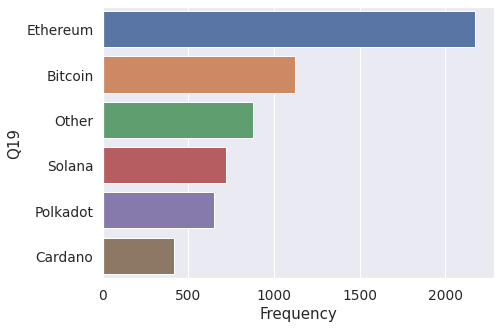

In [21]:
bar_plot_coded_column(df_questions, 'Q19', threshold=10, label='Q19')

Observations:
- 

### Are responses to individual questions correlated?
For all pairs of questions, calculate the correlation Cramer's V, then plot the resulting correlation matrix.

/home/notchia/anaconda3/envs/metagov/lib/python3.9/site-packages/scipy/stats/contingency.py:393: RuntimeWarning: invalid value encountered in double_scalars
  value = phi2 / min(n_cols - 1, n_rows - 1)
/home/notchia/anaconda3/envs/metagov/lib/python3.9/site-packages/scipy/stats/contingency.py:393: RuntimeWarning: invalid value encountered in double_scalars
  value = phi2 / min(n_cols - 1, n_rows - 1)


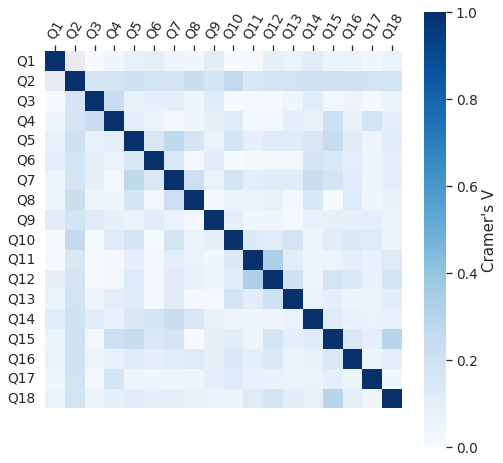

In [22]:
cramersMatrix = compute_cramers_v_matrix(df_questions[COLS_QUESTIONS].iloc[:, :-1])
df_cramer = pd.DataFrame(cramersMatrix, index=COLS_QUESTIONS[:-1], columns=COLS_QUESTIONS[:-1])
plot_cramers_v_matrix(df_cramer)

From a quick glance, most questions have little correlation with one another. One exception may be a correlation between Q2 ("Which blockchain is the best?") and some of the other questions; we explore this below, in the section on "Bitcoin versus Ethereum". 

Note that there is not any implication of significance (p-value) in these results. Grey boxes indicate uncomputable correlations (e.g., Q2 is only answered for one answer to Q1; responses to Q19 were lists).

## Bitcoin versus Ethereum
Are there any differences in responses and faction assignments between people affiliated with each of these ecosystems?

Note that these are not mutually exclusive groups!

In [23]:
def margin_of_error(fraction, nSample):
    """Compute margin of error for 95% confidence interval"""
    return 1.96*np.sqrt(fraction*(1-fraction)/nSample)

In [24]:
def get_q19_reduced(affiliations):
    aff_reduced = []
    if isinstance(affiliations, list):
        for ecosystem in ['Ethereum', 'Bitcoin']:
            if ecosystem in affiliations:
                aff_reduced.append(ecosystem)
    if len(aff_reduced) == 0:
        aff_reduced = ['Neither']
    return aff_reduced

# Select respondents who included an affiliation with Ethereum or Bitcoin
optCol = 'Q19'
df_tmp = df_questions_nonan[pd.notnull(df_questions[optCol])][COLS_QUESTIONS]
df_eth = df_tmp.loc[df_tmp[optCol].apply(lambda x: 'Ethereum' in x)].drop(columns=[optCol])
df_btc = df_tmp.loc[df_tmp[optCol].apply(lambda x: 'Bitcoin' in x)].drop(columns=[optCol])
df_both = df_tmp.loc[df_tmp[optCol].apply(lambda x: ('Bitcoin' in x) and ('Ethereum' in x))].drop(columns=[optCol])
df_neither = df_tmp.loc[df_tmp[optCol].apply(lambda x: not ('Bitcoin' in x) and not ('Ethereum' in x))].drop(columns=[optCol])

print("Number of Ethereum affiliates:  ", len(df_eth.index))
print("Number of Bitcoin affiliates:   ", len(df_btc.index))
print("Number affiliated with both:    ", len(df_both.index))
print("Number affiliated with neither: ", len(df_neither.index))

Number of Ethereum affiliates:   2175
Number of Bitcoin affiliates:    1120
Number affiliated with both:     789
Number affiliated with neither:  1204


### Most common responses to each question, for each affiliation

In [25]:
df_eth.mode()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18
0,There is no one best blockchain.,(No answer),Crypto is mainly an economic technology.,My goal in crypto is to create social change a...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto can do some go...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Most crypto teams make a fair and reasonable a...,The economic system in crypto is generally fai...,Most people who want to get ahead in crypto ca...,Work hand-in-hand with regulators to identify ...,Crypto does not have a gender problem.,A wide variety of on- and off-chain stakeholde...,the tech,Liberal or left-wing


In [26]:
df_btc.mode()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18
0,There is no one best blockchain.,(No answer),Crypto is mainly an economic technology.,My goal in crypto is to create social change a...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto will almost al...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Most crypto teams make a fair and reasonable a...,The economic system in crypto is generally fai...,Most people who want to get ahead in crypto ca...,Work hand-in-hand with regulators to identify ...,Crypto does not have a gender problem.,A wide variety of on- and off-chain stakeholde...,the tech,Neither


In [27]:
btc_vs_eth_questions = cryptopolitics.columns_where_rows_differ(pd.concat([df_eth.mode(), df_btc.mode()]))
print(f"Questions for which Bitcoin and Ethereum respondents had different mode responses:\n\t",
      ", ".join(btc_vs_eth_questions))

Questions for which Bitcoin and Ethereum respondents had different mode responses:
	 Q7, Q18


Differences between these groups are in questions **2 (best blockchain, if any)**, **7 (government regulation)**, and **18 (political affiliation)**.

In [28]:
Q19_dict = {'eth': df_eth, 'btc': df_btc}

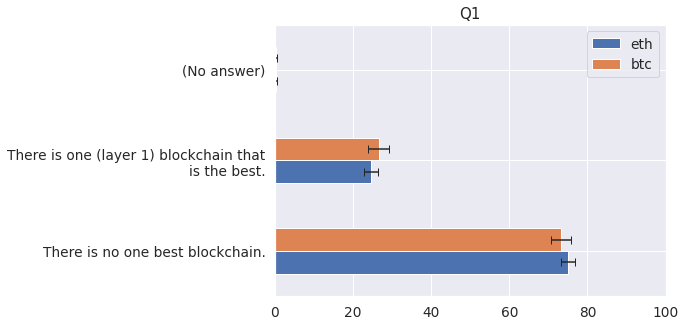

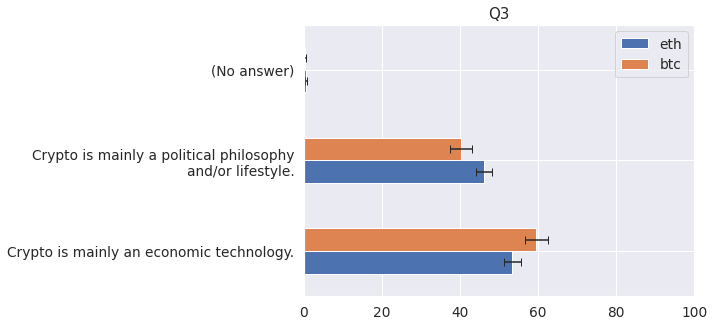

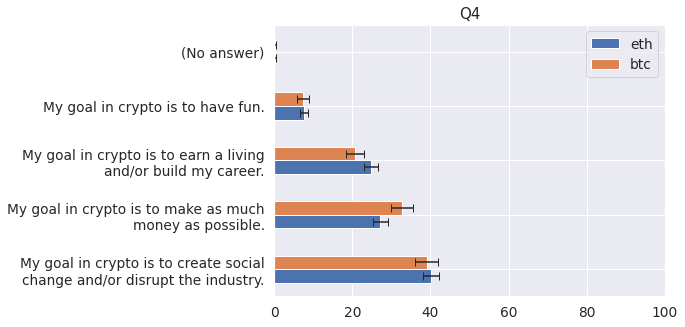

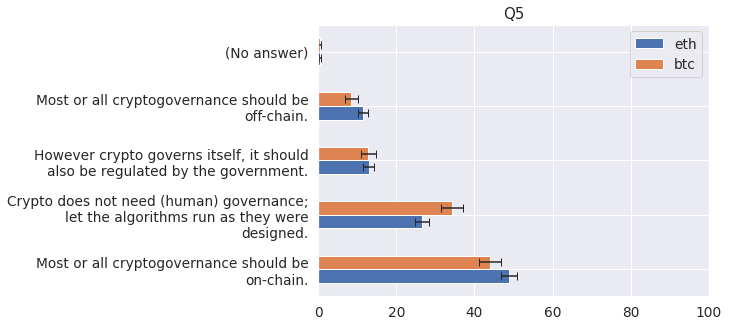

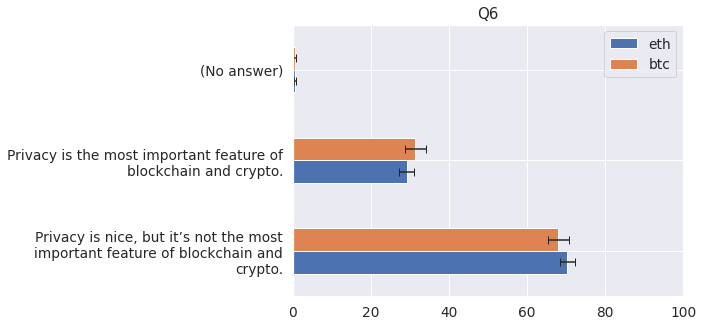

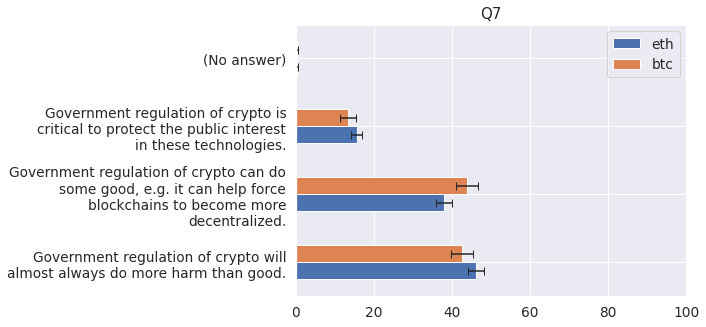

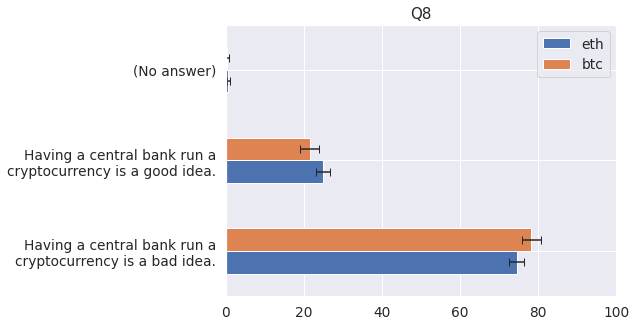

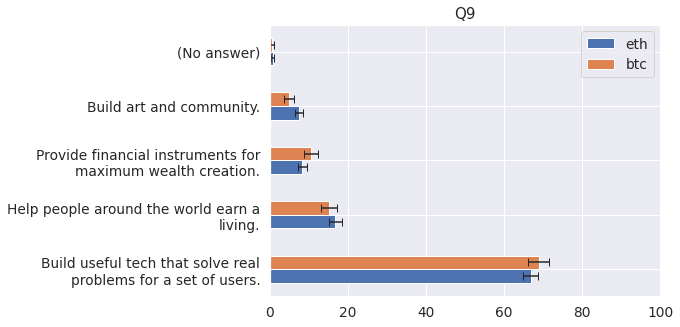

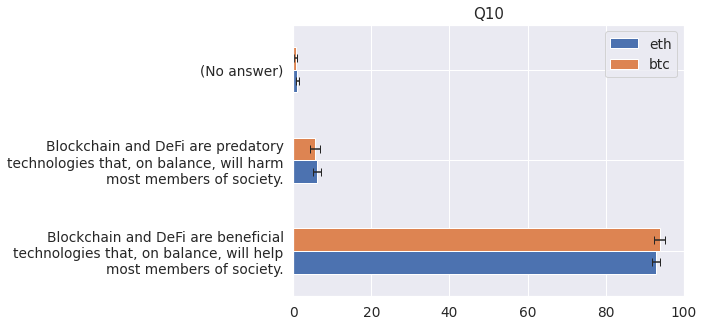

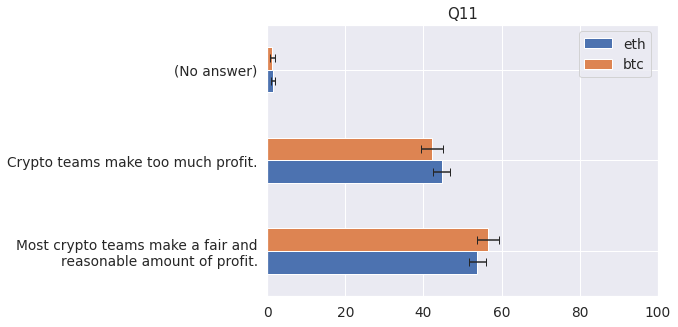

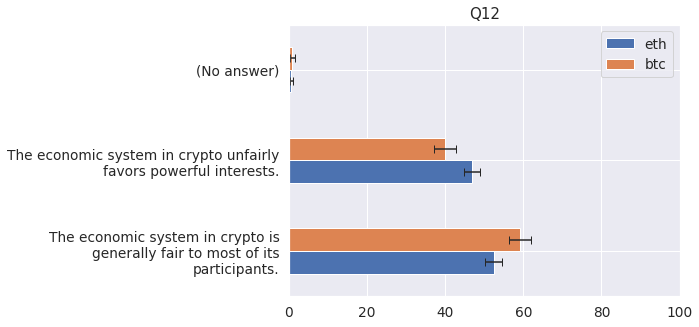

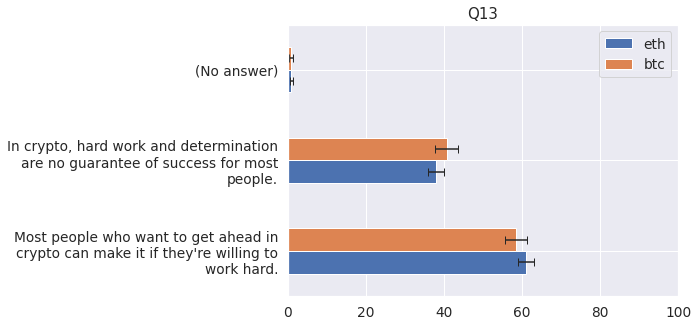

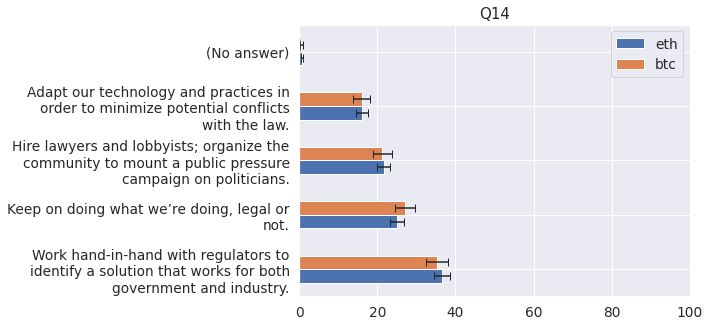

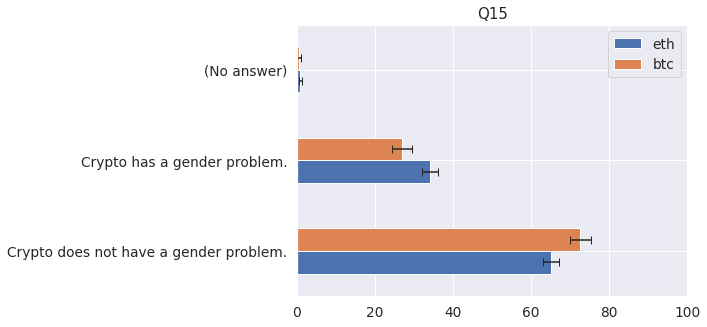

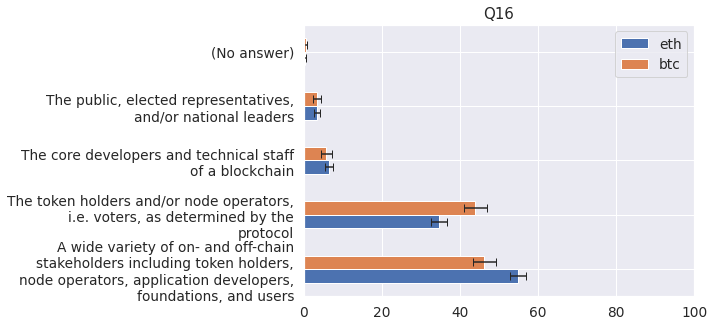

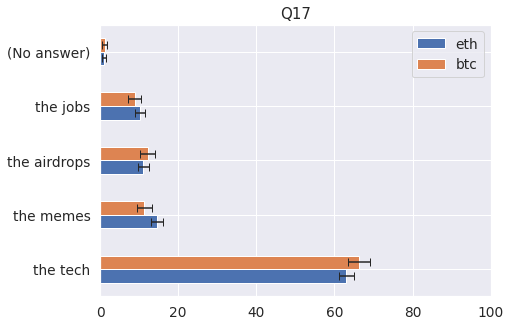

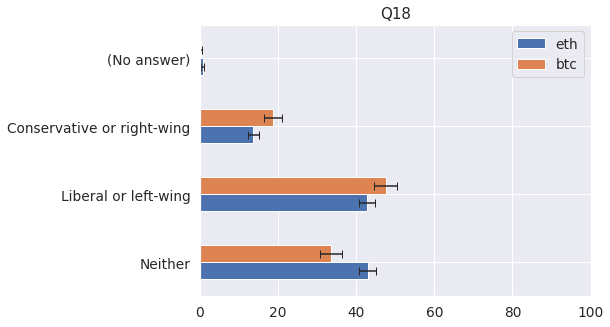

In [29]:
# Plot these differences in responses
for col in ['Q1', *COLS_QUESTIONS[2:-1]]:
    df_pct = pd.DataFrame()
    df_error = pd.DataFrame()
    for ecosys, df in Q19_dict.items():
        fractions = df[col].value_counts(normalize=True)  
        nSample = len(df.index)
        df_pct[ecosys] = fractions*100         
        df_error[ecosys] = pd.Series({choice: 100*margin_of_error(fraction, nSample) for choice, fraction in fractions.items()})

    choices = list(fractions.index)
    labels = ["\n".join(textwrap.wrap(c, width=40)) for c in choices]        
        
    ax = df_pct.plot.barh(title=col, xlim=(0,100), xerr=df_error, capsize=4)
    ax.set(yticklabels=labels)

    if SAVEFIG:
        fname = f"{SAVEDIR}/crytopolitics_btc-v-eth_{col}"
        plt.savefig(f'{fname}.{fig_ext}', **fig_kwargs)

### Differences in distribution of assigned factions

/home/notchia/anaconda3/envs/metagov/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/notchia/anaconda3/envs/metagov/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


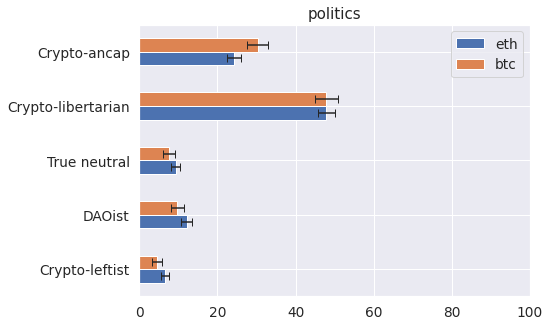

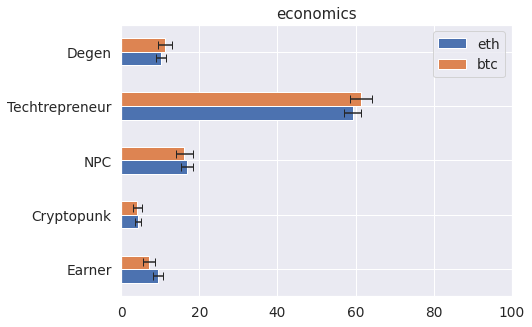

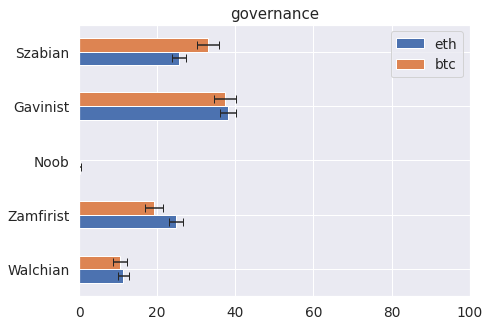

In [30]:
# Plot differences in assigned factions/classes
for col in COLS_RESULTS[1:]:   
    choices = FACTION_ORDERS[col]
    
    df_pct = pd.DataFrame()
    df_error = pd.DataFrame()
    for ecosys, df in {'eth': df_eth, 'btc': df_btc}.items():
        df_r = df_results[df_results.index.isin(df.index)]
        fractions = df_r[col].value_counts(normalize=True).reindex(choices)
        nSample = len(df_r.index)
        df_pct[ecosys] = fractions*100         
        df_error[ecosys] = pd.Series({choice: 100*margin_of_error(fraction, nSample) for choice, fraction in fractions.items()})

    ax = df_pct.plot.barh(title=col, xlim=(0,100), xerr=df_error, capsize=4)
    
    if SAVEFIG:
        fname = f"{SAVEDIR}/crytopolitics_btc-v-eth_{col}"
        plt.savefig(f'{fname}.{fig_ext}', **fig_kwargs)

## Political orientation
Are there any differences in responses and faction assignments between people who identify as left-of-center, right-of-center, or neither?

In [31]:
# Select respondents who included an affiliation with Ethereum or Bitcoin
optCol = 'Q18'
df_tmp = df_questions_nonan[pd.notnull(df_questions[optCol])][COLS_QUESTIONS]

df_l = df_tmp.loc[df_tmp[optCol].apply(lambda x: x == 'Liberal or left-wing')].drop(columns=[optCol])
df_r = df_tmp.loc[df_tmp[optCol].apply(lambda x: x == 'Conservative or right-wing')].drop(columns=[optCol])
df_n = df_tmp.loc[df_tmp[optCol].apply(lambda x: x == 'Neither')].drop(columns=[optCol])

print("Number left-wing:   ", len(df_l.index))
print("Number right-wing:  ", len(df_r.index))
print("Number neither:     ", len(df_n.index))

Number left-wing:    1550
Number right-wing:   532
Number neither:      1599


In [32]:
Q18_dict = {'left': df_l, 'right': df_r, 'neither': df_n}

In [33]:
df_l.mode()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q19
0,There is no one best blockchain.,(No answer),Crypto is mainly an economic technology.,My goal in crypto is to create social change a...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto can do some go...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Crypto teams make too much profit.,The economic system in crypto unfairly favors ...,Most people who want to get ahead in crypto ca...,Work hand-in-hand with regulators to identify ...,Crypto does not have a gender problem.,A wide variety of on- and off-chain stakeholde...,the tech,[Ethereum]


In [34]:
df_r.mode()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q19
0,There is no one best blockchain.,(No answer),Crypto is mainly an economic technology.,My goal in crypto is to make as much money as ...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto will almost al...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Most crypto teams make a fair and reasonable a...,The economic system in crypto is generally fai...,Most people who want to get ahead in crypto ca...,Work hand-in-hand with regulators to identify ...,Crypto does not have a gender problem.,"The token holders and/or node operators, i.e. ...",the tech,[Ethereum]


In [35]:
df_n.mode()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q19
0,There is no one best blockchain.,(No answer),Crypto is mainly an economic technology.,My goal in crypto is to create social change a...,Most or all cryptogovernance should be on-chain.,"Privacy is nice, but it’s not the most importa...",Government regulation of crypto will almost al...,Having a central bank run a cryptocurrency is ...,Build useful tech that solve real problems for...,Blockchain and DeFi are beneficial technologie...,Most crypto teams make a fair and reasonable a...,The economic system in crypto is generally fai...,Most people who want to get ahead in crypto ca...,Work hand-in-hand with regulators to identify ...,Crypto does not have a gender problem.,A wide variety of on- and off-chain stakeholde...,the tech,[Ethereum]


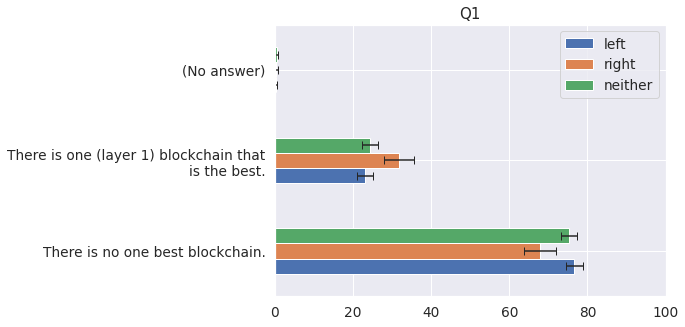

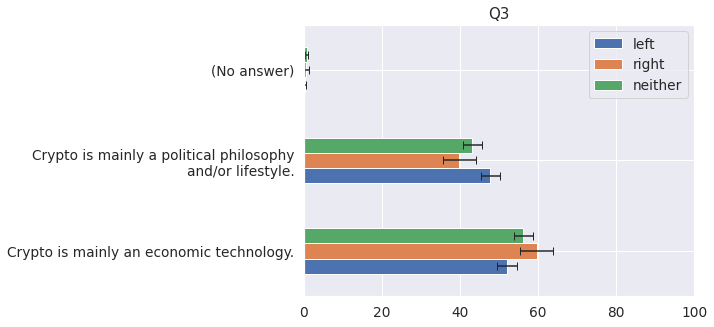

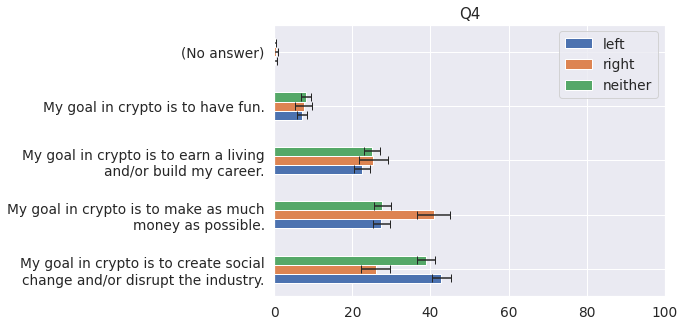

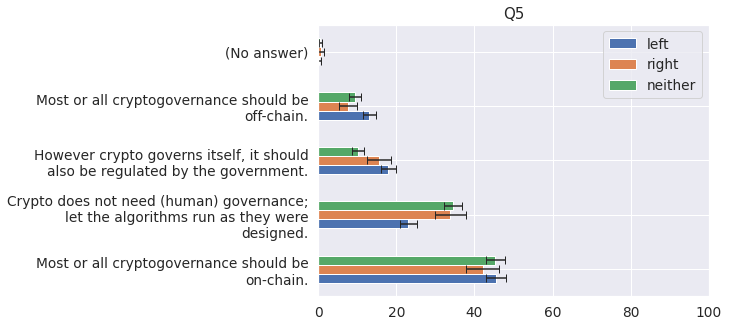

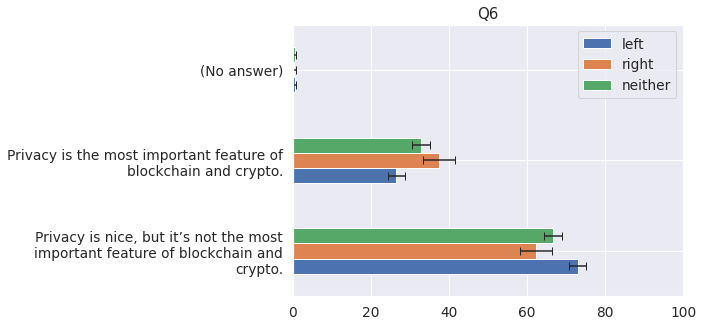

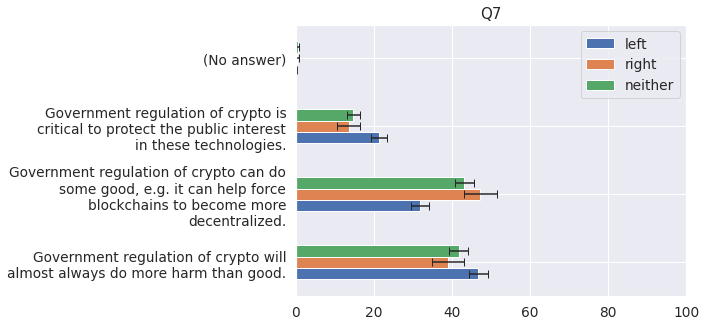

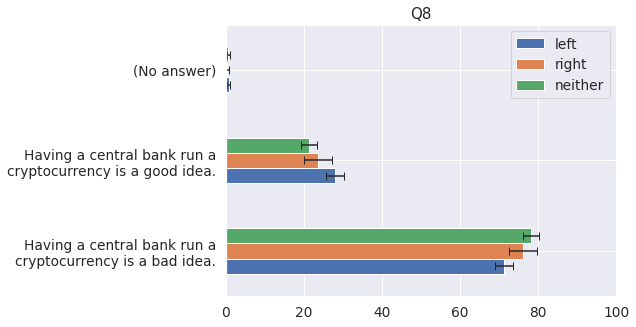

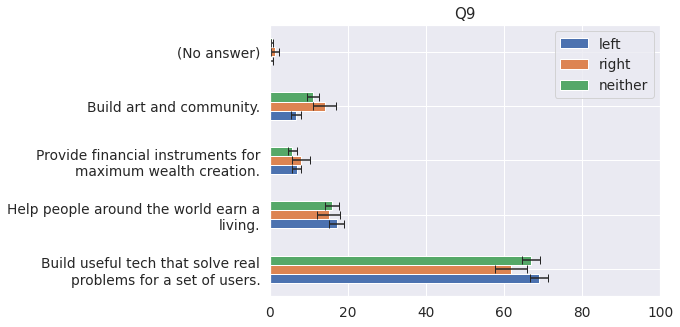

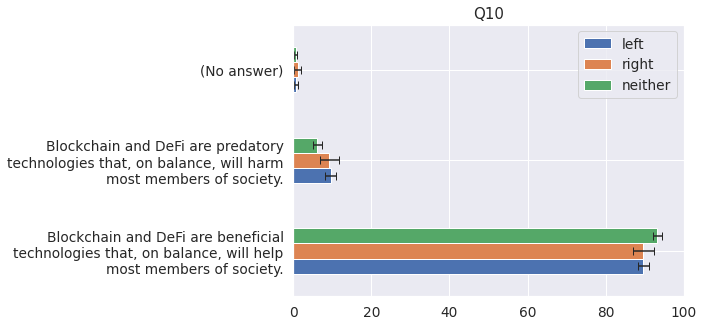

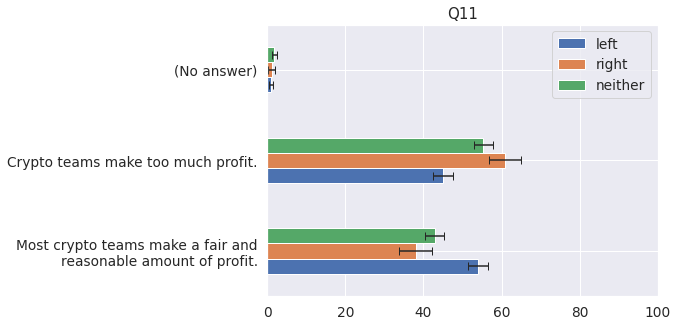

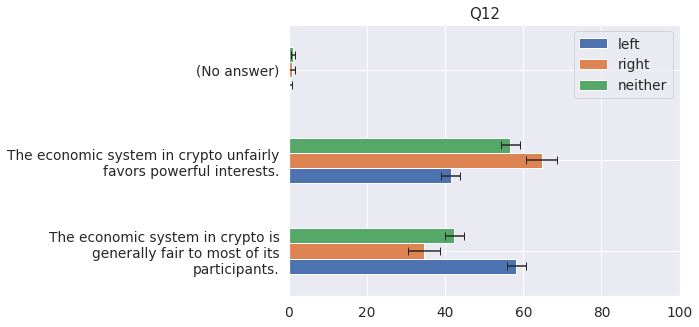

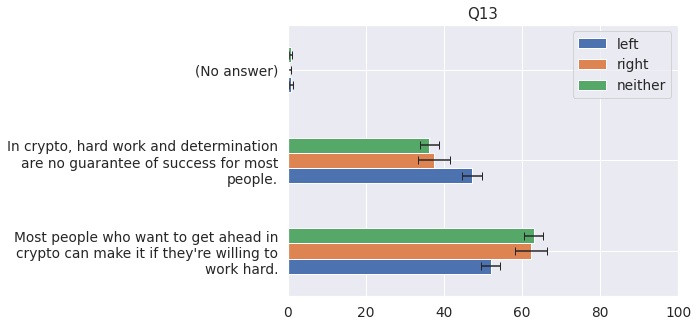

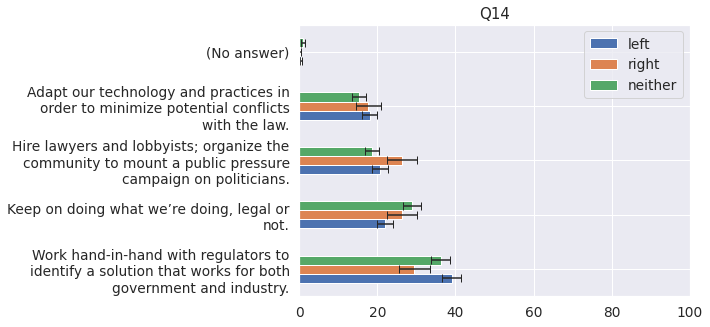

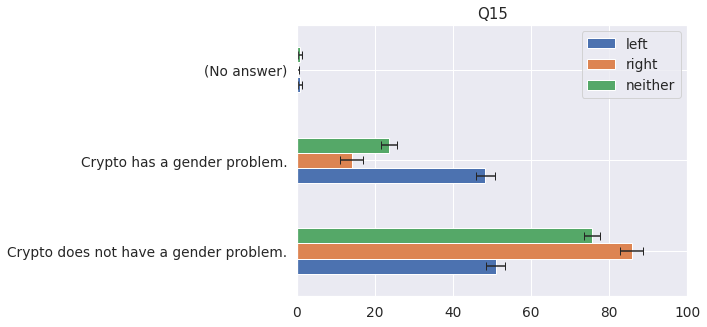

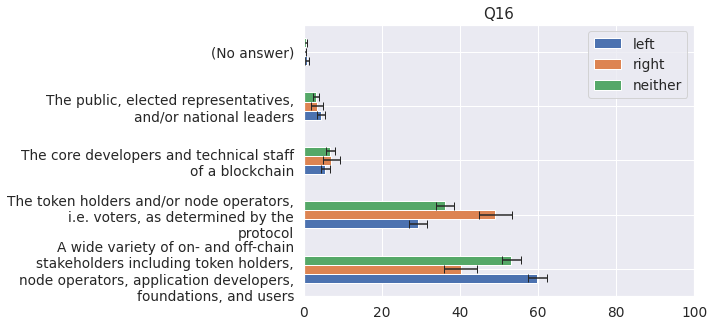

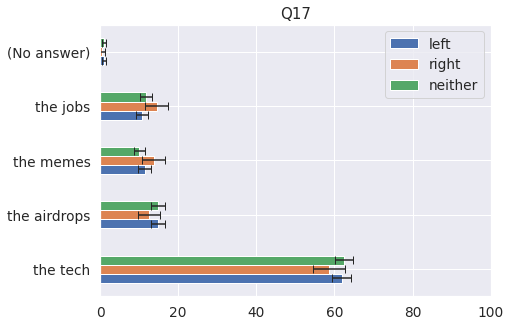

In [36]:
# Plot these differences in responses
for col in ['Q1', *COLS_QUESTIONS[2:-2]]:
    df_pct = pd.DataFrame()
    df_error = pd.DataFrame()
    for ecosys, df in Q18_dict.items():
        fractions = df[col].value_counts(normalize=True)  
        nSample = len(df.index)
        df_pct[ecosys] = fractions*100         
        df_error[ecosys] = pd.Series({choice: 100*margin_of_error(fraction, nSample) for choice, fraction in fractions.items()})

    choices = list(fractions.index)
    labels = ["\n".join(textwrap.wrap(c, width=40)) for c in choices]        
        
    ax = df_pct.plot.barh(title=col, xlim=(0,100), xerr=df_error, capsize=4)
    ax.set(yticklabels=labels)

    if SAVEFIG:
        fname = f"{SAVEDIR}/crytopolitics_orientation_{col}"
        plt.savefig(f'{fname}.{fig_ext}', **fig_kwargs)

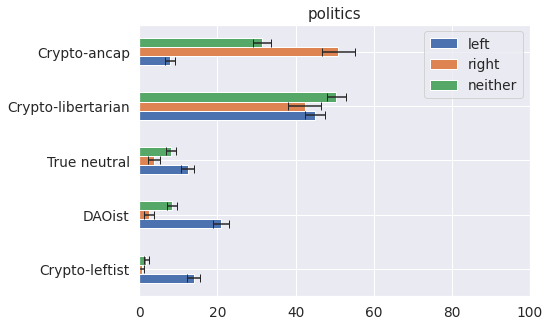

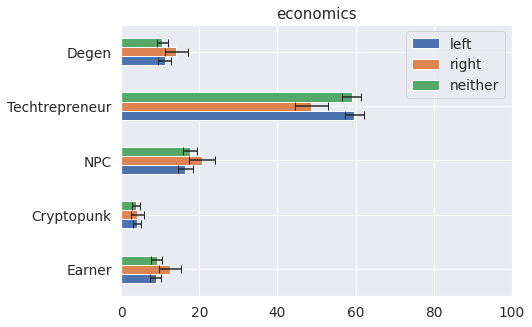

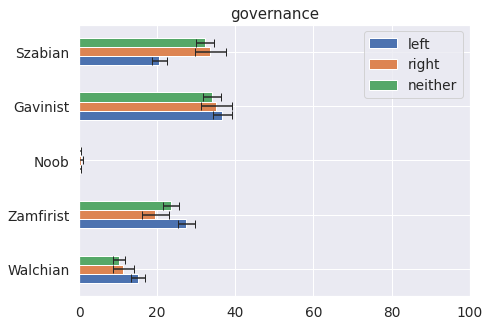

In [37]:
# Plot differences in assigned factions/classes
for col in COLS_RESULTS[1:]:   
    choices = FACTION_ORDERS[col]
    
    df_pct = pd.DataFrame()
    df_error = pd.DataFrame()
    for ecosys, df in Q18_dict.items():
        df_r = df_results[df_results.index.isin(df.index)]
        fractions = df_r[col].value_counts(normalize=True).reindex(choices)
        nSample = len(df_r.index)
        df_pct[ecosys] = fractions*100         
        df_error[ecosys] = pd.Series({choice: 100*margin_of_error(fraction, nSample) for choice, fraction in fractions.items()})

    ax = df_pct.plot.barh(title=col, xlim=(0,100), xerr=df_error, capsize=4)
    
    if SAVEFIG:
        fname = f"{SAVEDIR}/crytopolitics_orientation_{col}"
        plt.savefig(f'{fname}.{fig_ext}', **fig_kwargs)

## Correlation between blockchain affiliation and political orientation

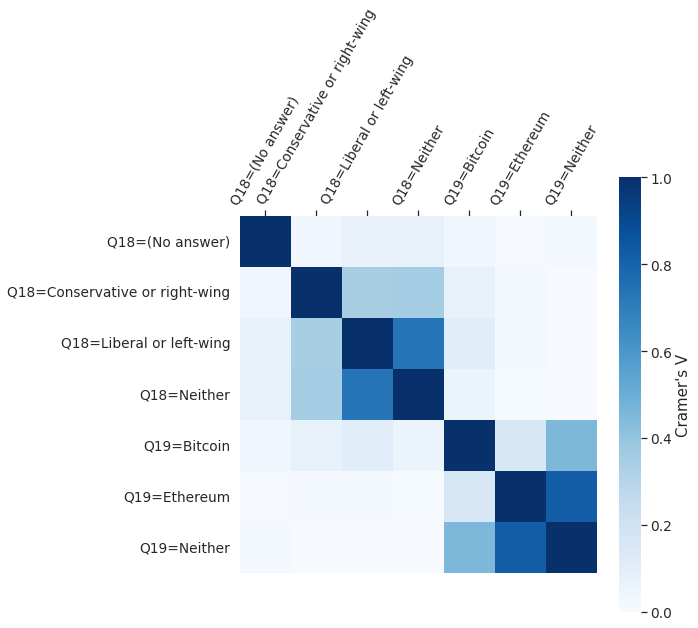

In [39]:
df_corr = df_questions_nonan[['Q18', 'Q19']].copy(deep=True)
df_corr['Q19'] = df_corr['Q19'].apply(get_q19_reduced)

v = DictVectorizer(sparse=False)
X_corr = v.fit_transform(df_corr.to_dict(orient='records'))
feature_names = v.get_feature_names_out()
df_corr = pd.DataFrame(X_corr, columns=feature_names)

cramersMatrix = compute_cramers_v_matrix(df_corr)
df_cramer = pd.DataFrame(cramersMatrix, index=feature_names, columns=feature_names)
plot_cramers_v_matrix(df_cramer)